Tasks:
- [Visualize primary and secondary needs](#primary_vs_secondary)
- Visualize primary vs taxonomy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import seaborn as sns

In [2]:
inter20 = pd.read_csv('./uwwi_datasets/uwwi_dataset_interactions/uwwi_dataset_interactions_2020.csv')
inter21 = pd.read_csv('./uwwi_datasets/uwwi_dataset_interactions/uwwi_dataset_interactions_2021.csv')
inter22 = pd.read_csv('./uwwi_datasets/uwwi_dataset_interactions/uwwi_dataset_interactions_2022.csv')

In [3]:
inter22.head()

,Client_Id,Interaction_CreateStamp,Interaction_ClientId,Interaction_Id,Interaction_CreateAccountId_href_label,Interaction_CreatePortalId,Interaction_CreateFormsetDeploymentId,Interaction_EditAccountId_href_label,Interaction_EditPortalId,Interaction_EditFormsetDeploymentId,...,InteractionOption_SwfSecondaryNeeds,InteractionOption_SwfCounty,InteractionOption_WhyWasThereNoReferralGiven,InteractionOption_UnableToContact,InteractionCustom_CallerReached,InteractionCustom_FollowUpUnmetNeeds,InteractionCustom_FollowUpComplete,InteractionCustom_FollowUpAttempt1,InteractionCustom_FollowUpAttempt2,InteractionCustom_FollowUpAttempt3
0,22934,2022-12-01T12:53:00.606552-06:00,22934,1405553,Lorena Lezama (805),1,689,Lorena Lezama (805),1,689,...,[],['Milwaukee'],[],[],Unselected,Unselected,Unselected,NaN,NaN,NaN
1,24900,2022-12-01T09:59:04.836496-06:00,24900,1405339,Teri Goodman (1258),1,689,Teri Goodman (1258),1,689,...,[],['Milwaukee'],[],[],Unselected,Unselected,Unselected,NaN,NaN,NaN
2,27820,2022-12-01T09:57:35.767512-06:00,27820,1405337,Melody Hobbs (743),1,689,Melody Hobbs (743),1,689,...,[],['Milwaukee'],[],[],Unselected,Unselected,Unselected,NaN,NaN,NaN
3,34433,2022-12-01T09:56:07.122672-06:00,34433,1405333,Teri Goodman (1258),1,689,Teri Goodman (1258),1,689,...,[],['Racine'],[],[],Unselected,Unselected,Unselected,NaN,NaN,NaN
4,24158,2022-12-01T08:58:26.516401-06:00,24158,1405271,Lorena Lezama (805),1,689,Lorena Lezama (805),1,689,...,[],['Milwaukee'],[],[],Unselected,Unselected,Unselected,NaN,NaN,NaN


In [5]:
inter22 = inter22.rename(columns={'InteractionOption_SwfPrimaryNeeds': 'Primary',
                        'InteractionOption_SwfSecondaryNeeds': 'Secondary'})

In [6]:
inter22['Secondary'].value_counts()

[]                                                                   7100
['Caller declined']                                                   270
['Warm Transferred']                                                    9
['Housing Payment Assistance']                                          5
['Food']                                                                4
['Other']                                                               3
['Mental Health', 'Other Financial Assistance']                         1
['Shelter']                                                             1
['Food', 'Other Financial Assistance']                                  1
['Shelter', 'Transportation']                                           1
['Housing Payment Assistance', 'Legal Assistance', 'Other']             1
['Utility/Energy', 'Other Financial Assistance']                        1
['Food', 'Transportation']                                              1
['Food', 'Utility/Energy', 'Housing Pa

In [7]:
df = (
inter22
.assign(Primary=inter22.Primary.apply(lambda x: literal_eval(x)),
        Secondary=inter22.Secondary.apply(lambda x: literal_eval(x))
       )
.explode('Primary')
.explode('Secondary')
[['Primary', 'Secondary']]
.query('Secondary!="Caller declined"')
.dropna()
.groupby(['Primary','Secondary'])['Secondary']
.count()
.reset_index(name='ct')
.pivot_table(index='Primary', columns='Secondary', values='ct')
.fillna(0)
)
df

Secondary,Food,Housing Payment Assistance,Legal Assistance,Mental Health,Other,Other Financial Assistance,Shelter,Transportation,Utility/Energy,Warm Transferred
Primary,,,,,,,,,,
Crisis,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
Food,1.0,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
Housing Payment Assistance,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Legal Assistance,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
Mental Health,1.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,2.0,4.0
Other,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0
Other Financial Assistance,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Shelter,1.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0
Supportive Listening,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [8]:
df = (df
     .assign(impact_on_secondary=df.sum(axis=1))
     .sort_values(by='impact_on_secondary', ascending=False)
     )
df.head()

Secondary,Food,Housing Payment Assistance,Legal Assistance,Mental Health,Other,Other Financial Assistance,Shelter,Transportation,Utility/Energy,Warm Transferred,impact_on_secondary
Primary,,,,,,,,,,,
Mental Health,1.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,2.0,4.0,13.0
Food,1.0,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,7.0
Shelter,1.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,6.0
Crisis,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0
Other,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,5.0


### Visualization: Primary vs Secondary needs
<a id='primary_vs_secondary'></a>

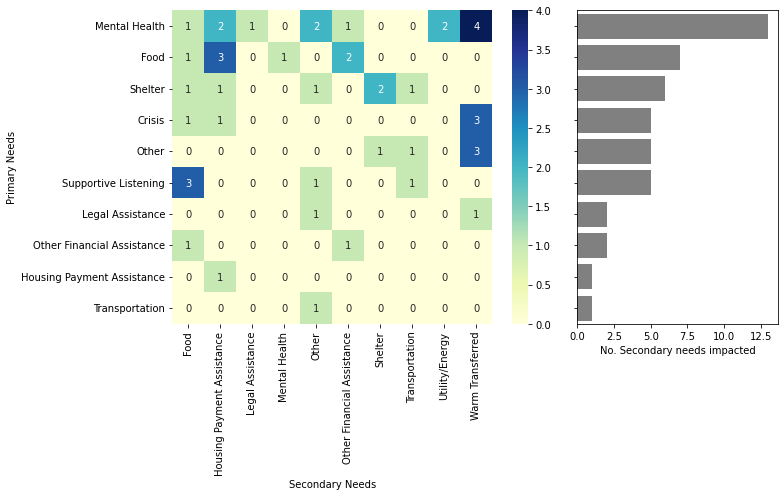

In [9]:
fig, axes = plt.subplots(1,2, figsize=(11, 7), gridspec_kw={'width_ratios': [2, 1]})

heat = sns.heatmap(df.drop('impact_on_secondary', axis=1), 
                   annot=True, 
                   cmap="YlGnBu", 
                   #cbar=False, 
                   ax=axes[0])
_ = heat.set(xlabel='Secondary Needs')
_ = heat.set(ylabel='Primary Needs')

bar = sns.barplot(x=df.impact_on_secondary, 
            y=df.index, 
            color='gray',
            ax=axes[1])
_ = bar.set(yticklabels=[])
_ = bar.set(ylabel=None)
_ = bar.set(xlabel='No. Secondary needs impacted')

fig.tight_layout()